In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set()

seed = 7111
np.random.seed(seed)
random_state = 2

import warnings
warnings.filterwarnings(action='once')


In [ ]:
df = pd.read_csv('./oasis_longitudinal.csv')
df.head()

classifiers = []


# Data exploration:

## Column data types:

In [ ]:
df.dtypes

Subject ID     object
MRI ID         object
Group          object
Visit           int64
MR Delay        int64
M/F            object
Hand           object
Age             int64
EDUC            int64
SES           float64
MMSE          float64
CDR           float64
eTIV            int64
nWBV          float64
ASF           float64
dtype: object

## Data description:

In [ ]:
df.describe()


,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


# Clean the data

In [ ]:
df = df.loc[df['Visit']==1] # use first visit data only because of the analysis we're doing
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

df.head()


,Subject ID,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0002,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046
2,OAS2_0004,0,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,OAS2_0005,0,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,OAS2_0007,1,0,1,71,16,NaN,28.0,0.5,1357,0.748,1.293


## Heatmap

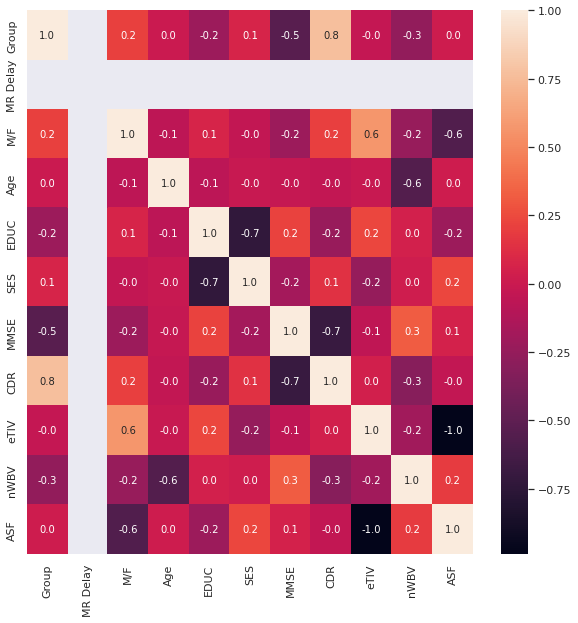

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,fmt='.1f')
plt.show()

## Pairplot

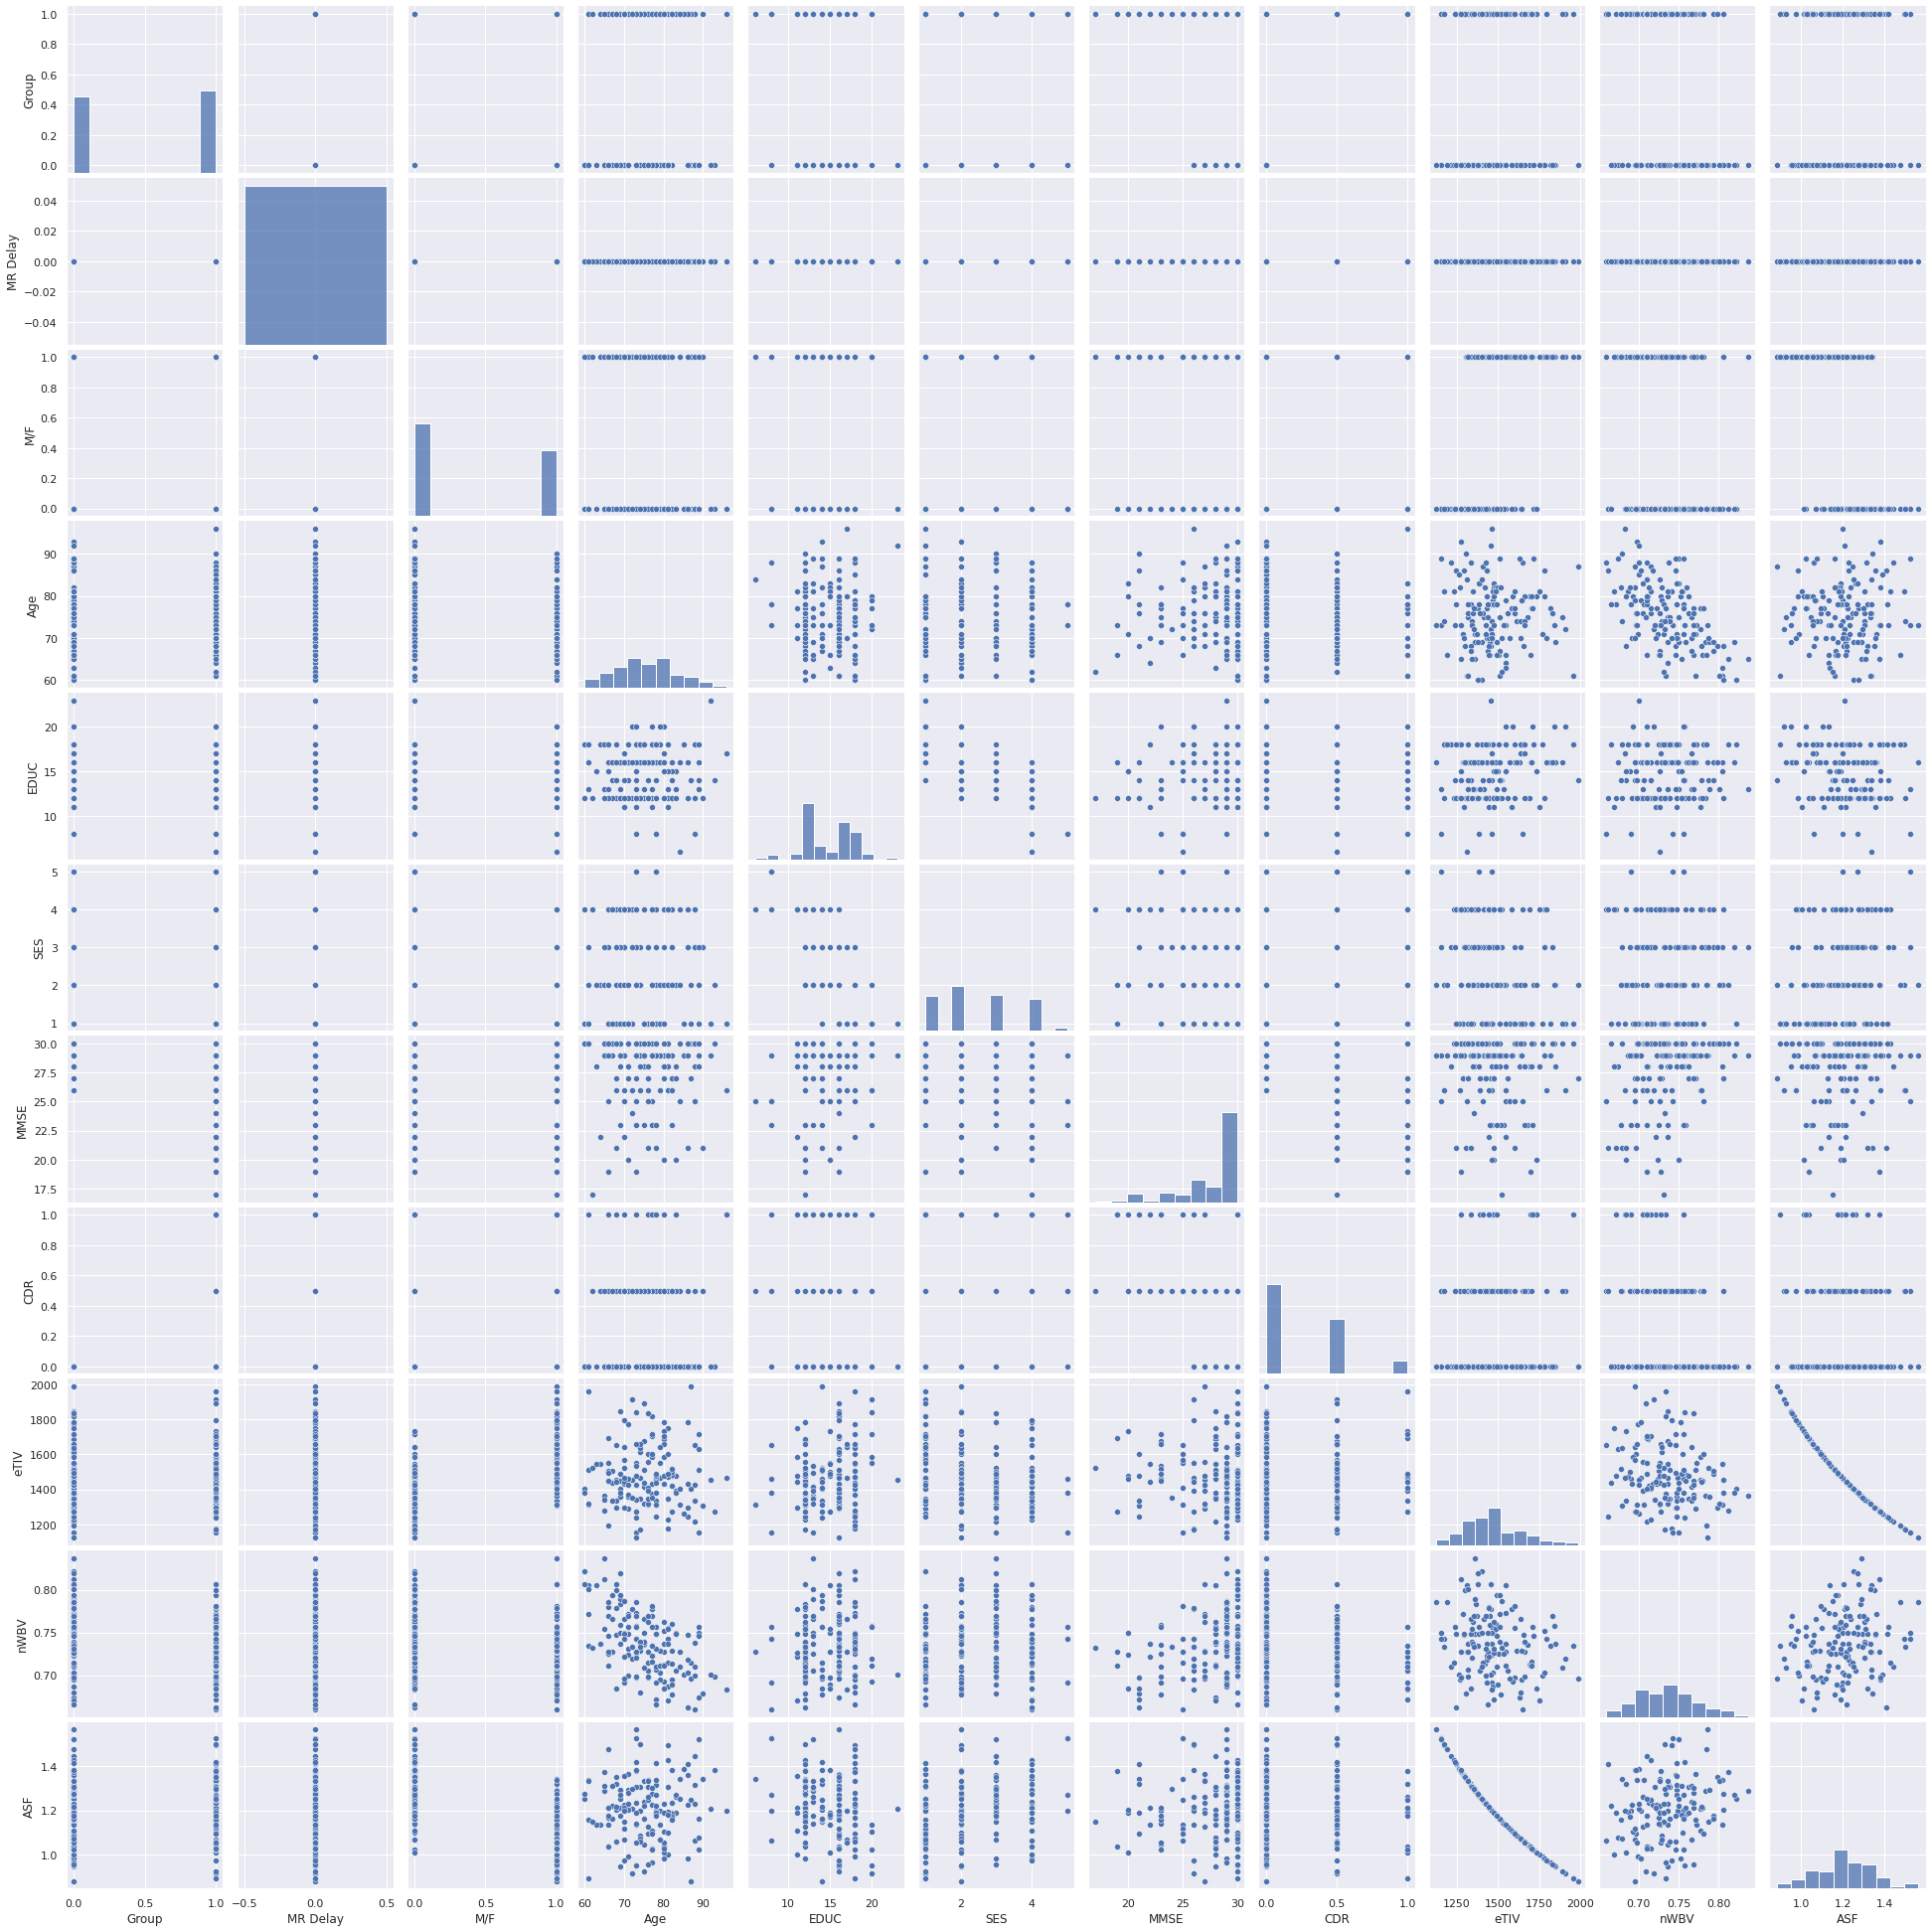

In [ ]:
sns.pairplot(df)
plt.show()

## Barcharts and gridplots

### Gender

Text(0.5, 1.0, 'Gender and Demented rate (Male = 1, Female = 0)')

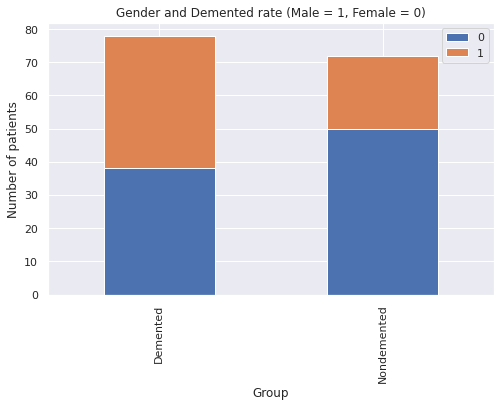

In [ ]:

# bar drawing function
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

# Gender  and  Group ( Female=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented rate (Male = 1, Female = 0)')


### (ASF) Atlas Scaling Factor


(0.5, 2.0)

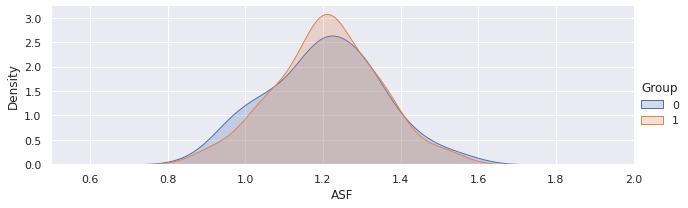

In [ ]:
#bar_chart('ASF') = Atlas Scaling Factor
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',shade= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)

### (eTIV) Estimated Total Intracranial Volume

(900.0, 2100.0)

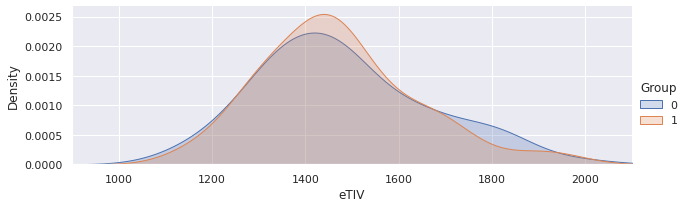

In [ ]:
#eTIV = Estimated Total Intracranial Volume
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',shade= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)


### (nWBV) Normalized Whole Brain Volume

(0.6, 0.9)

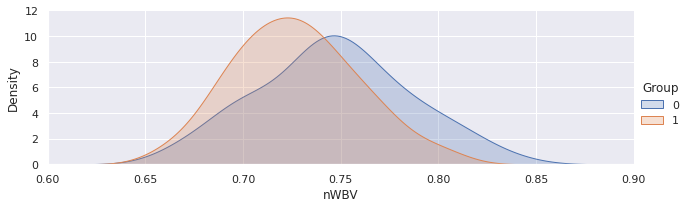

In [ ]:
#'nWBV' = Normalized Whole Brain Volume
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',shade= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)


## (MMSE) Mini Mental Grid Examination

(15.3, 30.0)

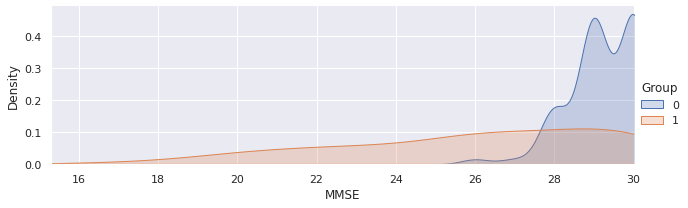

In [ ]:

#MMSE : Mini Mental State Examination
# Nondemented = 0, Demented =1
# Nondemented has higher test result ranging from 25 to 30.
#Min 17 ,MAX 30
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)


# Data Preporcessing

In [ ]:
df_dropna = df.dropna(axis=0, how='any')
pd.isnull(df_dropna).sum()

Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

## Imputation

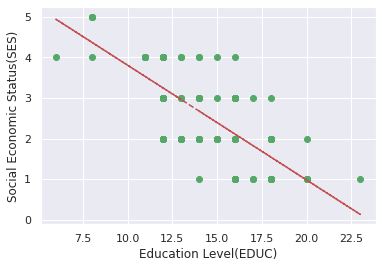

In [ ]:
# Draw scatter plot between EDUC and SES

def impute_plot():
    x = df['EDUC']
    y = df['SES']

    ses_not_null_index = y[~y.isnull()].index
    x = x[ses_not_null_index]
    y = y[ses_not_null_index]

    # Draw trend line in red
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, y, 'go', x, p(x), "r--")
    plt.xlabel('Education Level(EDUC)')
    plt.ylabel('Social Economic Status(SES)')

    plt.show()

impute_plot()

In [ ]:
df.groupby(['EDUC'])['SES'].median()
df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)

## Splitting

### Test Data

In [ ]:
# Dataset with imputation
Y = df['Group'].values # Target for the model
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)


# Dataset after dropping missing value rows
Y = df_dropna['Group'].values # Target for the model
X = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval_dna)
X_trainval_scaled_dna = scaler.transform(X_trainval_dna)
X_test_scaled_dna = scaler.transform(X_test_dna)

print(X_trainval_dna)

     M/F  Age  EDUC  SES  MMSE  eTIV   nWBV    ASF
57     0   81    18  2.0  29.0  1470  0.687  1.194
99     0   76    14  3.0  25.0  1409  0.715  1.246
54     1   61    18  1.0  30.0  1957  0.734  0.897
82     0   77    11  4.0  29.0  1583  0.777  1.108
114    0   76    16  3.0  26.0  1391  0.705  1.262
..   ...  ...   ...  ...   ...   ...    ...    ...
11     1   88     8  4.0  25.0  1651  0.660  1.063
108    0   78    12  3.0  29.0  1475  0.731  1.190
70     0   96    17  1.0  26.0  1465  0.683  1.198
122    0   81    13  2.0  29.0  1345  0.737  1.305
49     1   75    13  4.0  29.0  1416  0.766  1.239

[106 rows x 8 columns]


### Train Data

In [ ]:
print(X_test_dna)



     M/F  Age  EDUC  SES  MMSE  eTIV   nWBV    ASF
47     0   81    12  2.0  30.0  1599  0.755  1.098
71     1   78    12  4.0  21.0  1477  0.672  1.188
18     1   82    12  3.0  27.0  1420  0.713  1.236
59     0   83    13  2.0  27.0  1391  0.705  1.262
24     1   90    12  3.0  21.0  1307  0.679  1.342
9      0   81    12  4.0  30.0  1230  0.715  1.427
112    0   73    16  2.0  29.0  1123  0.786  1.563
148    1   80    16  1.0  28.0  1704  0.711  1.030
90     1   81    11  4.0  28.0  1750  0.670  1.003
105    0   76    16  1.0  28.0  1346  0.762  1.304
98     0   81    15  2.0  28.0  1486  0.754  1.181
132    1   82    14  2.0  23.0  1514  0.678  1.159
10     1   76    16  3.0  21.0  1602  0.697  1.096
103    0   74    12  3.0  29.0  1344  0.739  1.306
147    0   72    16  3.0  24.0  1354  0.733  1.296
35     0   75    18  1.0  30.0  1317  0.737  1.332
87     1   86    12  4.0  29.0  1783  0.703  0.984
88     0   70    11  4.0  22.0  1445  0.722  1.214
119    0   68    16  3.0  30.0 

# Models

## Logistic Regression


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated.

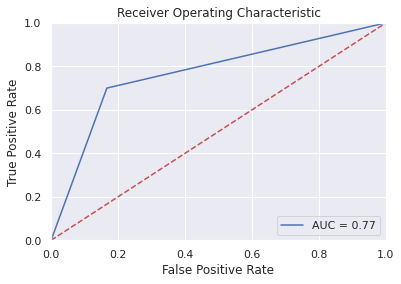

In [ ]:

acc = [] # list to store all performance metric

# Dataset with imputation
best_score=0
kfolds=5 # set the number of folds

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    # perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy') # Get recall for each parameter setting

    # compute mean cross-validation accuracy
    score = np.mean(scores)

    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = c

# rebuild a model on the combined training and validation set
logRegModel = LogisticRegression(C=best_parameters, random_state=random_state)
SelectedLogRegModel = logRegModel.fit(X_trainval_scaled, Y_trainval)
classifiers.append(logRegModel)

test_score = SelectedLogRegModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedLogRegModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

m = 'Logistic Regression (w/ imputation)'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])





### Result -  Logistic Regression


In [ ]:
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)


Best accuracy on validation set is: 0.7339920948616602
Best parameter for regularization (C) is:  10
Test accuracy with best C parameter is 0.7631578947368421
Test recall with the best C parameter is 0.7
Test AUC with the best C parameter is 0.7666666666666667


## SVM

best_parameter_c 100
best_parameter_gamma 0.1
best_parameter_k rbf


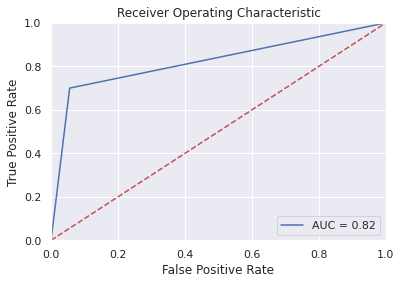

In [ ]:
from sklearn.svm import SVC

best_score = 0

for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: # iterate over the values we need to try for the kernel parameter
            svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter) #define the model
            # perform cross-validation
            scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            # the training set will be split internally into training and cross validation

            # compute mean cross-validation accuracy
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score #store the score
                best_parameter_c = c_paramter #store the parameter c
                best_parameter_gamma = gamma_paramter #store the parameter gamma
                best_parameter_k = k_parameter

print('best_parameter_c', best_parameter_c)
print('best_parameter_gamma', best_parameter_gamma)
print('best_parameter_k', best_parameter_k)


# rebuild a model with best parameters to get score
svmModel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k, random_state=random_state)
SelectedSVMmodel = svmModel.fit(X_trainval_scaled, Y_trainval)
classifiers.append(svmModel)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])


## Result - SVM

In [ ]:
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test AUC with the best parameter is", test_auc)




Best accuracy on cross validation set is: 0.7687747035573123
Best parameter for c is:  100
Best parameter for gamma is:  0.1
Best parameter for kernel is:  rbf
Test accuracy with the best parameters is 0.8157894736842105
Test recall with the best parameters is 0.7
Test AUC with the best parameter is 0.8222222222222222


## Decision Tree


Best accuracy on validation set is: 0.7770750988142293
Best parameter for the maximum depth is:  1
Test accuracy with best parameter is  0.8157894736842105
Test recall with best parameters is  0.65
Test AUC with the best parameter is  0.825
Feature importance: 
[['M/F' '0.0']
 ['Age' '0.0']
 ['EDUC' '0.0']
 ['SES' '0.0']
 ['MMSE' '1.0']
 ['eTIV' '0.0']
 ['nWBV' '0.0']
 ['ASF' '0.0']]


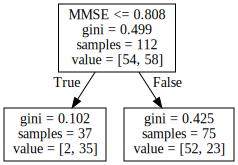

In [ ]:
best_score = 0

for md in range(1, 9): # iterate different maximum depth values
    # train the model
    treeModel = DecisionTreeClassifier(random_state=0, max_depth=md, criterion='gini')
    # perform cross-validation
    scores = cross_val_score(treeModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

    # compute mean cross-validation accuracy
    score = np.mean(scores)

    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameter = md

# Rebuild a model on the combined training and validation set
dtcModel = DecisionTreeClassifier(max_depth=best_parameter)
SelectedDTModel = dtcModel.fit(X_trainval_scaled, Y_trainval )
classifiers.append(dtcModel)

test_score = SelectedDTModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedDTModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for the maximum depth is: ", best_parameter)
print("Test accuracy with best parameter is ", test_score)
print("Test recall with best parameters is ", test_recall)
print("Test AUC with the best parameter is ", test_auc)

m = 'Decision Tree'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

print("Feature importance: ")
print(np.array([X.columns.values.tolist(), list(SelectedDTModel.feature_importances_)]).T)


from sklearn.tree import export_graphviz
import graphviz
dot_data=export_graphviz(SelectedDTModel, feature_names=X_trainval.columns.values.tolist(),out_file=None)
graph = graphviz.Source(dot_data)
graph


In [ ]:
X_trainval_scaled

array([[0.        , 0.36111111, 0.11764706, 1.        , 0.61538462,
        0.03240741, 0.52201258, 0.94411765],
       [0.        , 0.44444444, 0.35294118, 0.5       , 0.76923077,
        0.22222222, 0.23899371, 0.66470588],
       [0.        , 0.36111111, 0.58823529, 0.25      , 0.92307692,
        0.        , 0.79245283, 1.        ],
       [0.        , 0.77777778, 0.70588235, 0.5       , 0.84615385,
        0.10648148, 0.31446541, 0.825     ],
       [1.        , 0.22222222, 0.47058824, 0.5       , 0.69230769,
        0.37152778, 0.74213836, 0.48970588],
       [0.        , 0.61111111, 0.58823529, 0.5       , 0.92307692,
        0.41782407, 0.62893082, 0.44117647],
       [1.        , 0.44444444, 0.58823529, 0.5       , 0.30769231,
        0.55439815, 0.2327044 , 0.31323529],
       [0.        , 0.27777778, 0.47058824, 0.5       , 0.92307692,
        0.46412037, 0.79874214, 0.39411765],
       [0.        , 0.25      , 0.58823529, 0.5       , 0.92307692,
        0.2974537 , 1.      

### Random forest


In [ ]:

from sklearn.ensemble import RandomForestClassifier


best_score = 0

for M in range(2, 5, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 3): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)

            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m


# Rebuild a model on the combined training and validation set
rfcModel = RandomForestClassifier(n_estimators=best_M, max_features=best_d, max_depth=best_m)
# rfcModel = RandomForestClassifier(random_state=random_state)
SelectedRFModel = rfcModel.fit(X_trainval_scaled, Y_trainval)
classifiers.append(rfcModel)

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
# print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'Random Forest'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])



print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedRFModel.feature_importances_)]).T



/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Best accuracy on validation set is: 0.7770750988142293
Test accuracy with the best parameters is 0.8157894736842105
Test recall with the best parameters is: 0.65
Test AUC with the best parameters is: 0.825
Feature importance: 


array([['M/F', '0.0'],
       ['Age', '0.0'],
       ['EDUC', '0.0'],
       ['SES', '0.0'],
       ['MMSE', '1.0'],
       ['eTIV', '0.0'],
       ['nWBV', '0.0'],
       ['ASF', '0.0']], dtype='<U4')

### AdaBoost

Best accuracy on validation set is: 0.7770750988142293
Best parameter of M is:  2
best parameter of LR is:  0.0001
Test accuracy with the best parameter is 0.8157894736842105
Test recall with the best parameters is: 0.65
Test AUC with the best parameters is: 0.825


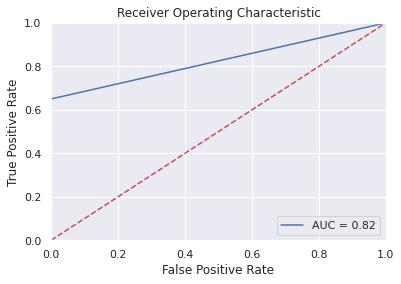

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

best_score = 0

for M in range(2, 15, 2): # combines M trees
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        # train the model
        boostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0)

        # perform cross-validation
        scores = cross_val_score(boostModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

        # compute mean cross-validation accuracy
        score = np.mean(scores)

        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_M = M
            best_lr = lr

# Rebuild a model on the combined training and validation set
adaModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0)
SelectedBoostModel = adaModel.fit(X_trainval_scaled, Y_trainval )
classifiers.append(adaModel)

PredictedOutput = SelectedBoostModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter of M is: ", best_M)
print("best parameter of LR is: ", best_lr)
print("Test accuracy with the best parameter is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

m = 'AdaBoost'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

# Bootstrap Aggregating or Bagging:

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LinearDiscriminantAnalysis())

        0. "LogisticRegression",
        1. "SVC",
        2. "DecisionTree",
        3. "RandomForest",
        4. "AdaBoost",
        5. "ExtraTrees",
        6. "GradientBoosting",
        7. "MultipleLayerPerceptron",
        8. "KNeighboors",
        9. "LinearDiscriminantAnalysis"

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


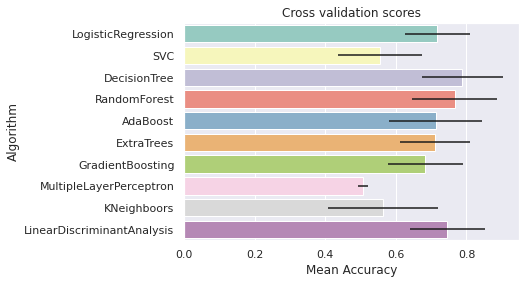

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms



cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X, y = Y, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
    "CrossValMeans":cv_means,
    "CrossValerrors": cv_std,
    "Algorithm":[
        "LogisticRegression",
        "SVC",
        "DecisionTree",
        "RandomForest",
        "AdaBoost",
        "ExtraTrees",
        "GradientBoosting",
        "MultipleLayerPerceptron",
        "KNeighboors",
        "LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

# Hyperparameter tuning

## Decision Tree



## Random Forest


In [ ]:
# # RFC Parameters tunning
# RFC = classifiers[]


# ## Search grid for optimal parameters
# rf_param_grid = {"max_depth": [None],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [2, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [False],
#               "n_estimators" :[100,300],
#               "criterion": ["gini"]}


# gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsRFC.fit(X,Y)

# RFC_best = gsRFC.best_estimator_

# # Best score
# gsRFC.best_score_

## Adaboost

In [ ]:
# from sklearn.model_selection import GridSearchCV

# ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
#               "base_estimator__splitter" :   ["best", "random"],
#               "algorithm" : ["SAMME","SAMME.R"],
#               "n_estimators" :[1,2],
#               "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

# gsadaDTC = GridSearchCV(classifiers[4],param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# gsadaDTC.fit(X,Y)

# ada_best = gsadaDTC.best_estimator_


In [ ]:
# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
#                         n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
#     """Generate a simple plot of the test and training learning curve"""
#     plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")

#     plt.legend(loc="best")
#     return plt

# g = plot_learning_curve(classifiers[4],"Adaboost learning curve",X,Y,cv=kfold)
# g = plot_learning_curve(classifiers[2],"DecisionTree learning curve",X,Y,cv=kfold)
# g = plot_learning_curve(classifiers[3],"Random forest learning curve",X,Y,cv=kfold)
# g = plot_learning_curve(classifiers[9],"LinearDiscriminantAnalysis learning curve",X,Y,cv=kfold)

## Voting Classifier

Recall Score 0.65
Hard Voting Score 0.8157894736842105


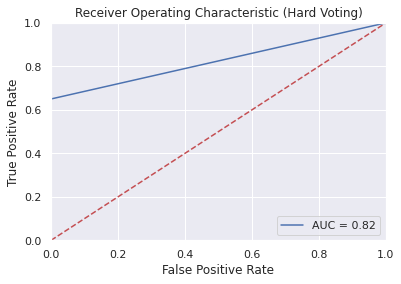

In [ ]:
from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[
                                       ('adaboost', classifiers[4]),
                                       ('svm', classifiers[1]),
                                       ('lr', classifiers[0]),
                                       ('dt', classifiers[2])], voting='hard', n_jobs=4)

# votingC = classifiers[3]

# scores = cross_val_score(classifiers[4], X, Y, cv=4, scoring='accuracy')
votingC.fit(X_trainval_scaled, Y_trainval)


yhat = votingC.predict(X_test_scaled)

test_recall = recall_score(Y_test, yhat, pos_label=1)

cl = accuracy_score(Y_test, yhat, normalize=True)
# print(f"Accurately classified {cl} out of {len(Y_test)}")
print(f"Recall Score {test_recall}") 
print(f"Hard Voting Score {cl}") 

# votingC = votingC.fit(X_trainval, Y_trainval)
# score = votingC.score(X_test, Y_test) 

fpr, tpr, thresholds = roc_curve(Y_test, yhat, pos_label=1)

plt.title('Receiver Operating Characteristic (Hard Voting)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# eclf = VotingClassifier(estimators=[('Ada Boost', ada_boost), ('Grad Boost', grad_boost), ('XG Boost', xgb_boost)], voting='hard')
# clf = [rf, et, knn, svc, rg]
# for clf, label in zip([ada_boost, grad_boost, xgb_boost,eclf], ['Ada Boost','Grad Boost','XG Boost','Ensemble']):
#     scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
   


In [ ]:
svmModel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k, random_state=random_state, probability=True)
SelectedSVMmodel = svmModel.fit(X_trainval_scaled, Y_trainval)
classifiers[1] = svmModel

Soft Voting Score 0.8157894736842105


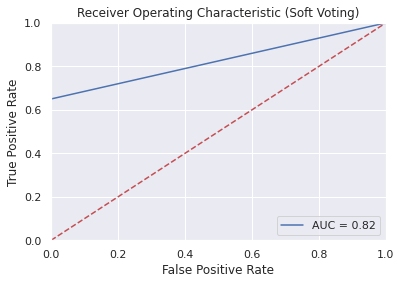

In [ ]:
from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[
                                       ('adaboost', classifiers[4]),
                                       ('svm', classifiers[1]),
                                       ('lr', classifiers[0]),
                                       ('dt', classifiers[2])], voting='soft', n_jobs=4)

# votingC = classifiers[3]

# scores = cross_val_score(classifiers[4], X, Y, cv=4, scoring='accuracy')
votingC.fit(X_trainval_scaled, Y_trainval)


yhat = votingC.predict(X_test_scaled)

cl = accuracy_score(Y_test, yhat, normalize=True)
# print(f"Accurately classified {cl} out of {len(Y_test)}")
print(f"Soft Voting Score {cl}") 

# votingC = votingC.fit(X_trainval, Y_trainval)
# score = votingC.score(X_test, Y_test) 

fpr, tpr, thresholds = roc_curve(Y_test, yhat, pos_label=1)

plt.title('Receiver Operating Characteristic (Soft Voting)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % test_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# eclf = VotingClassifier(estimators=[('Ada Boost', ada_boost), ('Grad Boost', grad_boost), ('XG Boost', xgb_boost)], voting='hard')
# clf = [rf, et, knn, svc, rg]
# for clf, label in zip([ada_boost, grad_boost, xgb_boost,eclf], ['Ada Boost','Grad Boost','XG Boost','Ensemble']):
#     scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
   
